## miscellanous import

In [ ]:
import gzip
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from statistics import median
from __future__ import annotations
from typing import Any, Dict, Optional
from datetime import datetime, timezone

## Read in the data

In [ ]:
DATA_DIR = Path("data")
LABELS_PATH = DATA_DIR / "data.info.labelled"
DATASET_PATH = DATA_DIR / "dataset0.json.gz"
OUT_CSV = DATA_DIR / "features_dataset0.csv"

# Minimum reads to keep a site (set to 1 to keep all)
MIN_READS = 1

# ---------- HELPERS ----------

def is_drach(center_5mer: str) -> bool:
    """Return True if 5-mer matches DRACH (D=[A/G/T], R=[A/G], A, C, H=[A/C/T])."""
    if len(center_5mer) != 5:
        return False
    D = set("AGT")
    R = set("AG")
    H = set("ACT")
    c = center_5mer.upper()
    return (c[0] in D) and (c[1] in R) and (c[2] == "A") and (c[3] == "C") and (c[4] in H)


def parse_record(line: str):
    """
    Parse one JSONL line with structure:
      {transcript_id: {position: {heptamer: [[9 features], ...] } } }
    Return tuple:
      (transcript_id:str, position:int, heptamer:str, reads:list[list[float]])
    Raise ValueError if structure invalid.
    """
    obj = json.loads(line)

    if not isinstance(obj, dict) or len(obj) != 1:
        raise ValueError("Top-level must be a dict with exactly one transcript_id key")

    transcript_id, inner1 = next(iter(obj.items()))
    if not isinstance(inner1, dict) or len(inner1) != 1:
        raise ValueError("Second level must be a dict with exactly one position key")

    position_str, inner2 = next(iter(inner1.items()))
    try:
        position = int(position_str)
    except Exception as e:
        raise ValueError(f"Position key must be int-convertible, got: {position_str}") from e

    if not isinstance(inner2, dict) or len(inner2) != 1:
        raise ValueError("Third level must be a dict with exactly one heptamer key")

    heptamer, reads = next(iter(inner2.items()))
    if not isinstance(heptamer, str) or len(heptamer) < 5:
        raise ValueError(f"Heptamer must be a string (len>=5), got: {heptamer}")

    if not isinstance(reads, list):
        raise ValueError("Reads must be a list of lists with 9 numeric features each")

    # Basic read shape validation (allow empty list; we'll filter later)
    for r in reads[:5]:  # spot-check first few to avoid heavy cost on huge sites
        if not (isinstance(r, list) and len(r) == 9 and all(isinstance(x, (int, float)) for x in r)):
            raise ValueError("Each read must be a list of 9 numeric features")

    return transcript_id, position, heptamer, reads


def robust_quantiles(arr: np.ndarray, qs=(0.25, 0.75)):
    """Return quantiles as a tuple for given probabilities."""
    if arr.size == 0:
        return (np.nan,) * len(qs)
    return tuple(np.quantile(arr, q) for q in qs)


def aggregate_reads(reads):
    """
    Given list of reads [[9 features]...], return dict of aggregated stats.
    Stats per base feature (9 of them): mean, std, median, q25, q75, iqr, min, max
    """
    arr = np.asarray(reads, dtype=float)
    if arr.ndim != 2 or arr.shape[1] != 9:
        raise ValueError("Reads array must be N x 9")

    stats = {}
    # Name the 9 base features
    base_names = [
        "m1_dt", "m1_sd", "m1_mean",
        "c_dt", "c_sd", "c_mean",
        "p1_dt", "p1_sd", "p1_mean",
    ]

    for j, feat in enumerate(base_names):
        col = arr[:, j]
        # Clean inf/nan
        col = col[np.isfinite(col)]
        if col.size == 0:
            # If all invalid, fill with nan
            stats[f"{feat}_mean"] = np.nan
            stats[f"{feat}_std"] = np.nan
            stats[f"{feat}_median"] = np.nan
            stats[f"{feat}_q25"] = np.nan
            stats[f"{feat}_q75"] = np.nan
            stats[f"{feat}_iqr"] = np.nan
            stats[f"{feat}_min"] = np.nan
            stats[f"{feat}_max"] = np.nan
            continue

        q25, q75 = robust_quantiles(col, (0.25, 0.75))
        stats.update({
            f"{feat}_mean": float(np.mean(col)),
            f"{feat}_std": float(np.std(col, ddof=1)) if col.size > 1 else 0.0,
            f"{feat}_median": float(np.median(col)),
            f"{feat}_q25": float(q25),
            f"{feat}_q75": float(q75),
            f"{feat}_iqr": float(q75 - q25),
            f"{feat}_min": float(np.min(col)),
            f"{feat}_max": float(np.max(col)),
        })

    return stats


def load_labels(path: Path) -> pd.DataFrame:
    dtypes = {
        "gene_id": "string",
        "transcript_id": "string",
        "transcript_position": "int32",
        "label": "int8",
    }
    df = pd.read_csv(path, dtype=dtypes)
    # Ensure uniqueness on key; if duplicates exist, keep the first and warn.
    dup_mask = df.duplicated(subset=["transcript_id", "transcript_position"], keep=False)
    if dup_mask.any():
        n_dup = int(dup_mask.sum())
        print(f"[WARN] {n_dup} duplicate label rows on (transcript_id, transcript_position); keeping first per key.")
        df = df.drop_duplicates(subset=["transcript_id", "transcript_position"], keep="first")
    return df


# ---------- MAIN PIPELINE ----------

def main():
    # Load labels
    print("Loading labels...")
    df_info = load_labels(LABELS_PATH)
    labels_map = {
        (tid, int(pos)): int(lbl)
        for tid, pos, lbl in zip(
            df_info["transcript_id"].astype(str),
            df_info["transcript_position"].astype(int),
            df_info["label"]
        )
    }

    print("df_info:", df_info.shape)

    # Prepare output CSV (streaming write)
    OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
    header_written = False

    n_lines = 0
    n_kept = 0
    n_skipped_empty = 0
    n_invalid = 0
    n_non_drach = 0

    with gzip.open(DATASET_PATH, "rt", encoding="utf-8") as f, open(OUT_CSV, "w", encoding="utf-8") as fout:
        for line in tqdm(f, desc="Processing dataset0.json.gz"):
            n_lines += 1
            line = line.strip()
            if not line:
                continue
            try:
                transcript_id, position, heptamer, reads = parse_record(line)
            except Exception as e:
                n_invalid += 1
                if n_invalid <= 5:
                    print(f"[WARN] Invalid record at line {n_lines}: {e}")
                continue

            if not reads or len(reads) < MIN_READS:
                n_skipped_empty += 1
                continue

            # Aggregate per-site
            stats = aggregate_reads(reads)
            n_reads = len(reads)

            # Central 5-mer is positions 2..6 of heptamer (0-based 1:6)
            center_5mer = heptamer[1:6] if len(heptamer) >= 6 else heptamer[:5]
            drach_flag = is_drach(center_5mer)
            if not drach_flag:
                n_non_drach += 1  # informative; per spec it should be DRACH

            row = {
                "transcript_id": transcript_id,
                "transcript_position": position,
                "heptamer": heptamer,
                "center_5mer": center_5mer,
                "is_drach": int(drach_flag),
                "n_reads": n_reads,
                **stats,
            }

            # Attach label if present (O(1) dict lookup)
            lbl = labels_map.get((str(transcript_id), int(position)))
            row["label"] = lbl if lbl is not None else pd.NA


            # Stream-write row
            row_df = pd.DataFrame([row])
            if not header_written:
                row_df.to_csv(fout, index=False)
                header_written = True
            else:
                row_df.to_csv(fout, index=False, header=False)
            n_kept += 1

    print("\nDone.")
    print(f" Total lines read:        {n_lines}")
    print(f" Kept (with >= {MIN_READS} reads): {n_kept}")
    print(f" Skipped (empty/low cov): {n_skipped_empty}")
    print(f" Invalid structure:       {n_invalid}")
    print(f" Non-DRACH centers:       {n_non_drach}")
    print(f" Wrote features to:       {OUT_CSV}")


if __name__ == "__main__":
    main()

Loading labels...
df_info: (121838, 4)


Processing dataset0.json.gz: 121838it [05:08, 394.86it/s]


Done.
 Total lines read:        121838
 Kept (with >= 1 reads): 121838
 Skipped (empty/low cov): 0
 Invalid structure:       0
 Non-DRACH centers:       0
 Wrote features to:       data\features_dataset0.csv


## Helper functions

In [16]:
# Minimal save + evaluate helpers

from pathlib import Path
from datetime import datetime
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# ---------- Saving ----------
def save_model_minimal(model, name="model", models_dir="models"):
    Path(models_dir).mkdir(parents=True, exist_ok=True)
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    path = Path(models_dir) / f"{name}_{ts}.joblib"
    joblib.dump(model, path)
    print(f"Saved: {path}")
    return path

# ---------- Evaluation (ROC + PRC + F1/Youden) ----------
def _safe_f1_vec(prec, rec):
    denom = prec + rec
    out = np.zeros_like(denom, dtype=float)
    m = denom > 0
    out[m] = 2 * (prec[m] * rec[m]) / denom[m]
    return out

def eval_scores(y_true, y_score, plot_prefix=None):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_score = np.asarray(y_score, dtype=float).ravel()

    # ROC
    fpr, tpr, thr_roc = roc_curve(y_true, y_score)
    auroc = roc_auc_score(y_true, y_score)
    j_vals = tpr - fpr
    j_idx = int(np.argmax(j_vals))
    thr_youden = float(thr_roc[j_idx])

    # PRC
    precision, recall, thr_pr = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    f1_vals = _safe_f1_vec(precision[:-1], recall[:-1])
    f1_idx = int(np.argmax(f1_vals))
    thr_f1 = float(thr_pr[f1_idx])

    # Plots
    # ROC
    plt.figure(figsize=(5.2, 4.2))
    plt.plot(fpr, tpr, label=f"AUROC={auroc:.3f}")
    plt.plot([0, 1], [0, 1], "--", lw=1)
    plt.scatter(fpr[j_idx], tpr[j_idx], marker="x", s=70, label=f"Youden thr={thr_youden:.3f}")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.tight_layout()
    if plot_prefix: plt.savefig(f"{plot_prefix}_roc.png", dpi=150)
    plt.show()

    # PR
    plt.figure(figsize=(5.2, 4.2))
    plt.plot(recall, precision, label=f"AP={ap:.3f}")
    plt.scatter(recall[f1_idx], precision[f1_idx], marker="x", s=70, label=f"Max-F1 thr={thr_f1:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve"); plt.legend(); plt.tight_layout()
    if plot_prefix: plt.savefig(f"{plot_prefix}_pr.png", dpi=150)
    plt.show()

    # Summaries at thresholds
    def _summary_at(thr):
        yp = (y_score >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
        return {
            "threshold": float(thr),
            "precision": float(precision_score(y_true, yp, zero_division=0)),
            "recall": float(recall_score(y_true, yp, zero_division=0)),
            "f1": float(f1_score(y_true, yp, zero_division=0)),
            "accuracy": float(accuracy_score(y_true, yp)),
            "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
        }

    out = {
        "auroc": float(auroc),
        "average_precision": float(ap),
        "best_f1_threshold": thr_f1,
        "youden_threshold": thr_youden,
        "at_best_f1": _summary_at(thr_f1),
        "at_youden": _summary_at(thr_youden),
    }
    return out

def evaluate_sklearn_minimal(model, X_test, y_test, plot_prefix=None):
    """Works with sklearn classifiers that implement predict_proba"""
    y_score = model.predict_proba(X_test)[:, 1]
    return eval_scores(y_test, y_score, plot_prefix=plot_prefix)

def evaluate_keras_minimal(model, X_test, y_test, plot_prefix=None):
    """For Keras models that output probabilities with model.predict()"""
    y_score = model.predict(X_test).ravel()
    return eval_scores(y_test, y_score, plot_prefix=plot_prefix)

def save_keras_minimal(model, name="keras_model", models_dir="models"):
    Path(models_dir).mkdir(parents=True, exist_ok=True)
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    path = Path(models_dir) / f"{name}_{ts}.keras"
    model.save(path)
    print(f"Saved: {path}")
    return path


# ---------- Example usage in a cell ----------
# pipe.fit(X_train, y_train)
# summary = evaluate_sklearn_minimal(pipe, X_test, y_test, plot_prefix="models/logreg")
# save_model_minimal(pipe, name="m6a_logreg")
# summary

## EDA

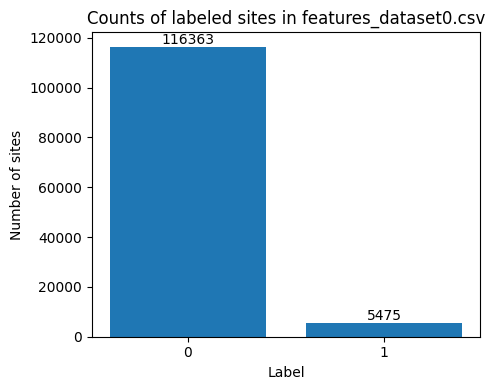

  label   count
0     0  116363
1     1    5475


In [ ]:
FEATURES_PATH = Path("data/features_dataset0.csv")

df = pd.read_csv(FEATURES_PATH)

df = df[df["label"].isin([0, 1])].copy()

counts = df["label"].value_counts().sort_index()
counts_df = pd.DataFrame({
    "label": ["0", "1"],
    "count": [int(counts.get(0, 0)), int(counts.get(1, 0))],
})

fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(counts_df["label"], counts_df["count"])
ax.set_title("Counts of labeled sites in features_dataset0.csv")
ax.set_xlabel("Label")
ax.set_ylabel("Number of sites")

for i, v in enumerate(counts_df["count"]):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

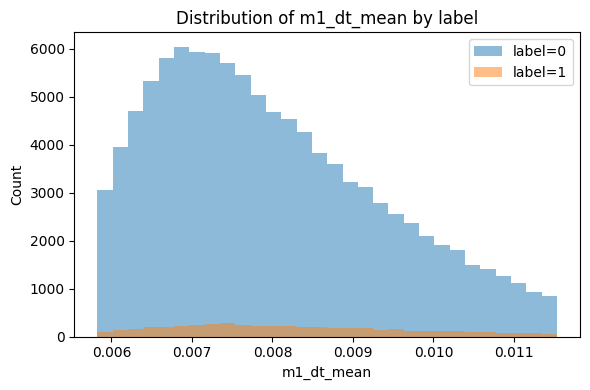

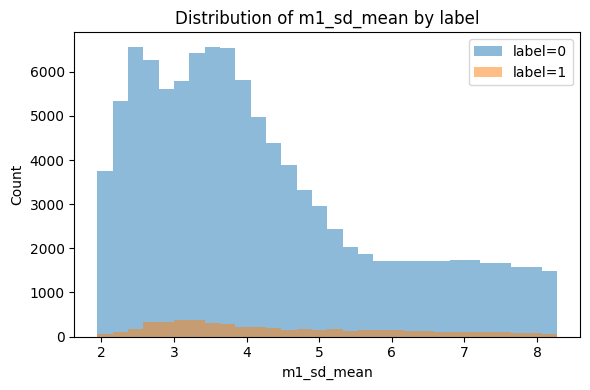

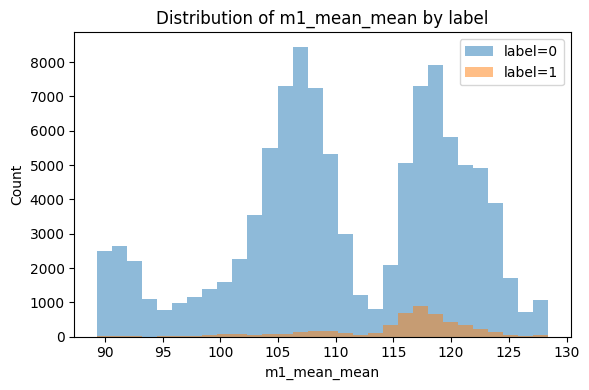

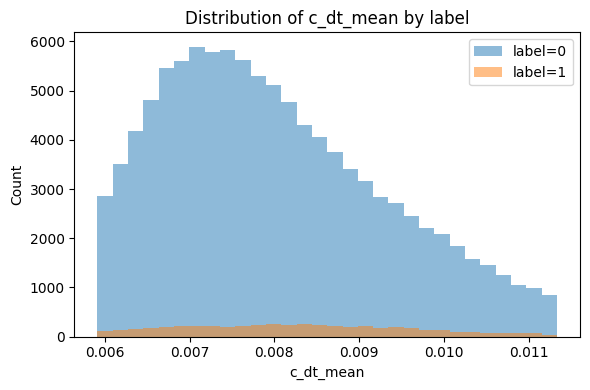

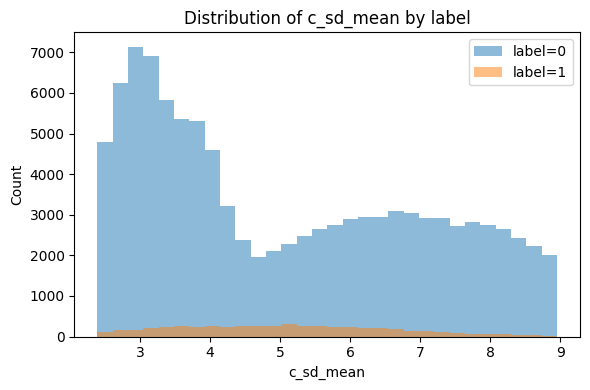

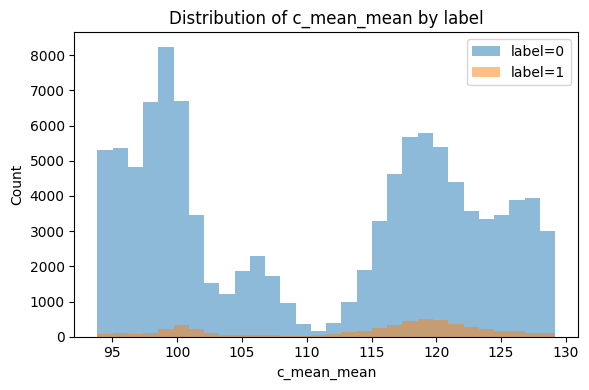

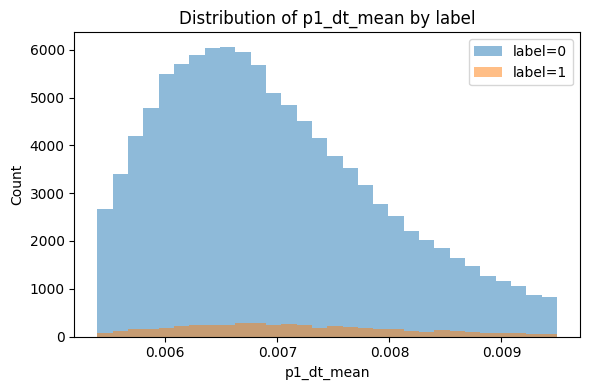

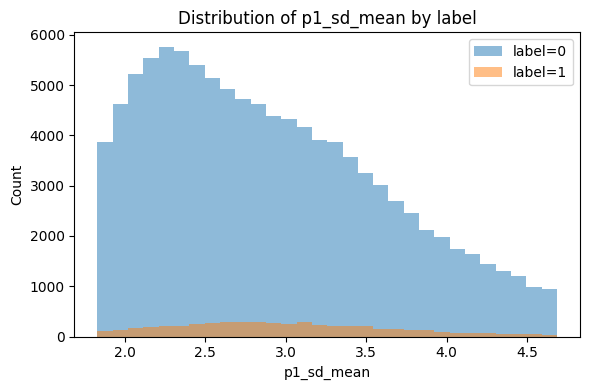

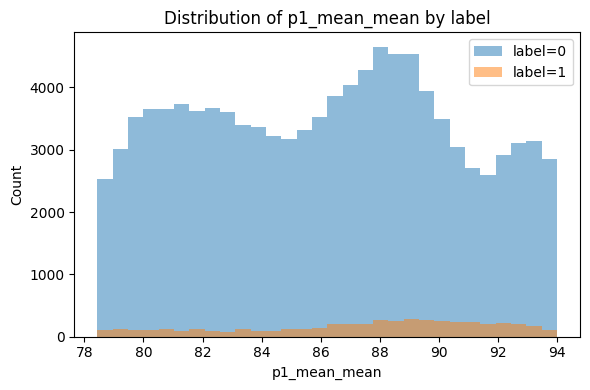

     feature  label  count       mean     median       std
   c_dt_mean      0 116363   0.008120   0.007819  0.001695
   c_dt_mean      1   5475   0.008278   0.008167  0.001634
 c_mean_mean      0 116363 110.761911 113.914286 12.539069
 c_mean_mean      1   5475 114.864291 118.100000  9.865094
   c_sd_mean      0 116363   5.161425   4.626129  2.208171
   c_sd_mean      1   5475   5.075140   5.012651  1.585414
  m1_dt_mean      0 116363   0.008094   0.007745  0.001782
  m1_dt_mean      1   5475   0.008405   0.008124  0.001850
m1_mean_mean      0 116363 110.541661 109.659468 11.375477
m1_mean_mean      1   5475 116.054781 117.206897  7.551773
  m1_sd_mean      0 116363   4.327787   3.824000  1.940280
  m1_sd_mean      1   5475   4.646910   4.174211  1.822596
  p1_dt_mean      0 116363   0.007046   0.006810  0.001295
  p1_dt_mean      1   5475   0.007283   0.007078  0.001301
p1_mean_mean      0 116363  86.173792  86.417840  4.936160
p1_mean_mean      1   5475  86.830278  87.964667  4.9209

In [12]:
base_feats = ["m1_dt","m1_sd","m1_mean","c_dt","c_sd","c_mean","p1_dt","p1_sd","p1_mean"]
stat_suffix = "_mean"

summary_rows = []
outdir = Path("eda_feature_dists")
outdir.mkdir(parents=True, exist_ok=True)

for base in base_feats:
    col = f"{base}{stat_suffix}"
    if col not in df.columns:
        print(f"[skip] {col} not found")
        continue

    d0 = df.loc[df["label"] == 0, col].replace([np.inf, -np.inf], np.nan).dropna()
    d1 = df.loc[df["label"] == 1, col].replace([np.inf, -np.inf], np.nan).dropna()

    # stats table
    for lbl, series in [(0, d0), (1, d1)]:
        mu = float(np.mean(series)) if len(series) else np.nan
        med = float(np.median(series)) if len(series) else np.nan
        sd = float(np.std(series, ddof=1)) if len(series) > 1 else (0.0 if len(series)==1 else np.nan)
        summary_rows.append({"feature": col, "label": lbl, "count": int(len(series)), "mean": mu, "median": med, "std": sd})

    # pick a robust plotting range to avoid extreme tails
    combined = pd.concat([d0, d1], axis=0)
    if len(combined) >= 10:
        lo, hi = np.quantile(combined, [0.05, 0.95])
        if lo == hi:
            lo, hi = combined.min(), combined.max()
    else:
        lo, hi = (combined.min() if len(combined) else 0.0, combined.max() if len(combined) else 1.0)

    fig, ax = plt.subplots(figsize=(6,4))
    if len(d0): ax.hist(d0, bins=30, alpha=0.5, range=(lo, hi), label="label=0")
    if len(d1): ax.hist(d1, bins=30, alpha=0.5, range=(lo, hi), label="label=1")
    ax.set_title(f"Distribution of {col} by label")
    ax.set_xlabel(col); ax.set_ylabel("Count")
    ax.legend()
    plt.tight_layout()
    plt.savefig(outdir / f"{col}_hist.png", dpi=150)
    plt.show()

summary_df = pd.DataFrame(summary_rows).sort_values(["feature","label"]).reset_index(drop=True)
print(summary_df.to_string(index=False))
summary_df.to_csv(outdir / "feature_distribution_summary.csv", index=False)
print(f"Saved figures and summary to: {outdir}")

## Preparing data

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ---------- Config ----------
FEATURES_PATH = Path("data/features_dataset0.csv")
TEST_SIZE = 0.20

# ---------- Load ----------
df = pd.read_csv(FEATURES_PATH)

# Keep only labeled rows
df = df[df["label"].isin([0, 1])].copy()
df["label"] = df["label"].astype(int)

# ---------- Engineer center–flank features (if source cols exist) ----------
# We use *_mean columns for deltas/ratios; skip gracefully if missing.
def add_center_flank_features(dfx: pd.DataFrame) -> pd.DataFrame:
    def safe_add_delta_ratio(df_, base: str):
        # base in {"dt","sd","mean"}; columns like c_dt_mean, m1_dt_mean, p1_dt_mean
        cm = f"c_{base}_mean"
        m1m = f"m1_{base}_mean"
        p1m = f"p1_{base}_mean"
        if cm in df_.columns and m1m in df_.columns:
            df_[f"delta_c_minus_m1_{base}"] = df_[cm] - df_[m1m]
            df_[f"ratio_c_over_m1_{base}"] = df_[cm] / (df_[m1m].replace(0, np.nan))
        if cm in df_.columns and p1m in df_.columns:
            df_[f"delta_c_minus_p1_{base}"] = df_[cm] - df_[p1m]
            df_[f"ratio_c_over_p1_{base}"] = df_[cm] / (df_[p1m].replace(0, np.nan))
    for b in ["dt", "sd", "mean"]:
        safe_add_delta_ratio(dfx, b)
    # Coverage transforms
    if "n_reads" in dfx.columns:
        dfx["log1p_n_reads"] = np.log1p(dfx["n_reads"].clip(lower=0))
    return dfx

df = add_center_flank_features(df)

# Replace infs created by ratios with NaN (will be imputed later)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# ---------- Define identifiers, target, and candidate features ----------
id_cols = [c for c in ["transcript_id", "transcript_position", "heptamer", "center_5mer"] if c in df.columns]
target_col = "label"

# numeric features (keep is_drach, n_reads, engineered cols, and all numeric aggregates)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# remove target from feature list
feature_cols = [c for c in num_cols if c != target_col]

# Sanity checks
if not feature_cols:
    raise ValueError("No numeric feature columns found. Check your features_dataset0.csv.")

if "transcript_id" not in df.columns:
    # If transcript_id missing, fall back to random split (not ideal)
    print("[WARN] transcript_id not found; using random split without grouping.")
    groups = np.arange(len(df))
else:
    groups = df["transcript_id"].astype(str).values

# ---------- Group-aware split (by transcript) ----------
gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE)
train_idx, test_idx = next(gss.split(df, df[target_col].values, groups=groups))

train_df = df.iloc[train_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

# ---------- Build X/y ----------
X_train_df = train_df[feature_cols].copy()
X_test_df  = test_df[feature_cols].copy()
Y_train = train_df[target_col].astype(int).values
Y_test  = test_df[target_col].astype(int).values

# ---------- Preprocessing pipeline: median impute + standardize (fit on train only) ----------
preproc = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
])

X_train = preproc.fit_transform(X_train_df)   # numpy array
X_test  = preproc.transform(X_test_df)

# ---------- Report ----------
print(f"Train size: {X_train.shape[0]} sites, Test size: {X_test.shape[0]} sites")
print(f"Features: {X_train.shape[1]} columns")
print("Positive rate (train): {:.3f}".format(Y_train.mean()))
print("Positive rate (test):  {:.3f}".format(Y_test.mean()))

feature_names = feature_cols
scaler_pipeline = preproc


Train size: 97360 sites, Test size: 24478 sites
Features: 88 columns
Positive rate (train): 0.046
Positive rate (test):  0.043


## Now is the fucking training part

### Logistic Regression

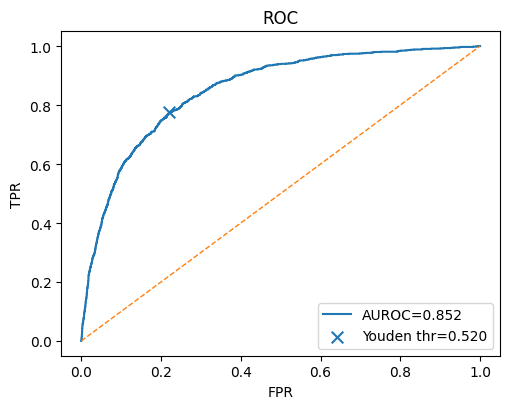

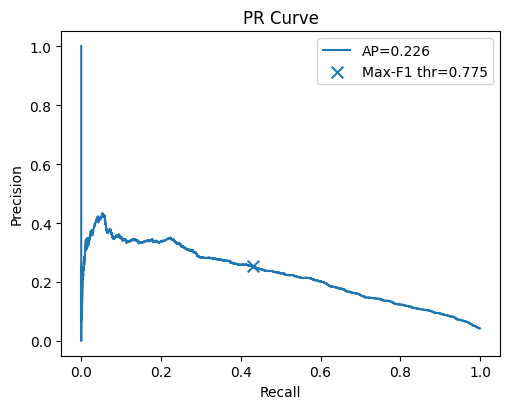

=== Test summary (LR) ===
auroc = 0.8516249422919504
average_precision = 0.22585437024852098
best_f1_threshold = 0.7747329031320842
youden_threshold = 0.5198799418611874
at_best_f1 = {'threshold': 0.7747329031320842, 'precision': 0.25525866969869243, 'recall': 0.4296650717703349, 'f1': 0.3202567760342368, 'accuracy': 0.9221341612876869, 'tp': 449, 'fp': 1310, 'tn': 22123, 'fn': 596}
at_youden = {'threshold': 0.5198799418611874, 'precision': 0.13527054108216433, 'recall': 0.7751196172248804, 'f1': 0.23034267026873312, 'accuracy': 0.7788626521774655, 'tp': 810, 'fp': 5178, 'tn': 18255, 'fn': 235}
Saved: models\m6a_logreg_20251012T075828Z.joblib


C:\Users\DELL\AppData\Local\Temp\ipykernel_21212\3600405145.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


WindowsPath('models/m6a_logreg_20251012T075828Z.joblib')

In [ ]:
from pathlib import Path
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

clf = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    class_weight="balanced", 
    random_state=42,
)

clf.fit(X_train, Y_train)

PLOT_PREFIX = "models/logreg"
Path(PLOT_PREFIX).parent.mkdir(parents=True, exist_ok=True)
summary = evaluate_sklearn_minimal(clf, X_test, Y_test, plot_prefix=PLOT_PREFIX)
print("=== Test summary (LR) ===")
for k, v in summary.items():
    print(k, "=", v)

bundle = make_pipeline(scaler_pipeline, clf)
save_model_minimal({"pipeline": bundle, "feature_names": feature_names}, name="m6a_logreg")


### Gradient boost trees

scale_pos_weight ≈ 20.98
[LightGBM] [Info] Number of positive: 4430, number of negative: 92930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21347
[LightGBM] [Info] Number of data points in the train set: 97360, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045501 -> initscore=-3.043447
[LightGBM] [Info] Start training from score -3.043447


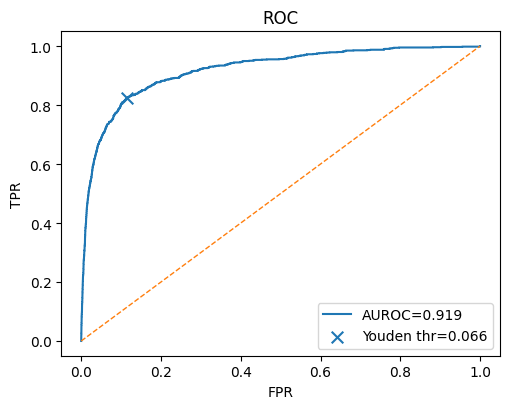

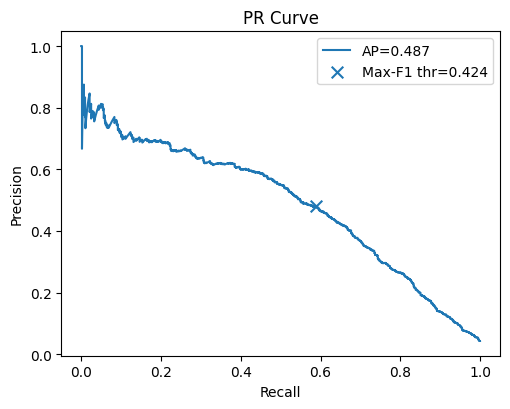

=== Test summary (LightGBM) ===
auroc = 0.9189294858169387
average_precision = 0.4869435784470224
best_f1_threshold = 0.4235325481067777
youden_threshold = 0.06626893858223144
at_best_f1 = {'threshold': 0.4235325481067777, 'precision': 0.4793774319066148, 'recall': 0.5894736842105263, 'f1': 0.5287553648068669, 'accuracy': 0.9551433940681429, 'tp': 616, 'fp': 669, 'tn': 22764, 'fn': 429}
at_youden = {'threshold': 0.06626893858223144, 'precision': 0.2430908065425832, 'recall': 0.8248803827751197, 'f1': 0.3755173164887824, 'accuracy': 0.8828744178445952, 'tp': 862, 'fp': 2684, 'tn': 20749, 'fn': 183}
Saved: models\m6a_gbm_20251012T075646Z.joblib


C:\Users\DELL\AppData\Local\Temp\ipykernel_21212\3600405145.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


WindowsPath('models/m6a_gbm_20251012T075646Z.joblib')

In [ ]:
from pathlib import Path
import numpy as np
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier

pos_weight = (Y_train == 0).sum() / max(1, (Y_train == 1).sum())
print(f"scale_pos_weight ≈ {pos_weight:.2f}")

# Model
lgbm = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=30,
    objective="binary",
    scale_pos_weight=pos_weight,
    random_state=42,
    n_jobs=-1,
)

lgbm.fit(X_train, Y_train)

PLOT_PREFIX = "models/gbm"
Path(PLOT_PREFIX).parent.mkdir(parents=True, exist_ok=True)
summary_gbm = evaluate_sklearn_minimal(lgbm, X_test, Y_test, plot_prefix=PLOT_PREFIX)
print("=== Test summary (LightGBM) ===")
for k, v in summary_gbm.items():
    print(k, "=", v)

deploy_bundle = make_pipeline(scaler_pipeline, lgbm)
save_model_minimal({"pipeline": deploy_bundle, "feature_names": feature_names}, name="m6a_gbm")


### Linear with ridge

[corr] dropped 28 / 88 columns (>|r|>0.95)
[univariate] selected top-40 by combined AUC+MI


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[l1] kept 60 non-zero features (of 60)
[final] 60 features selected


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


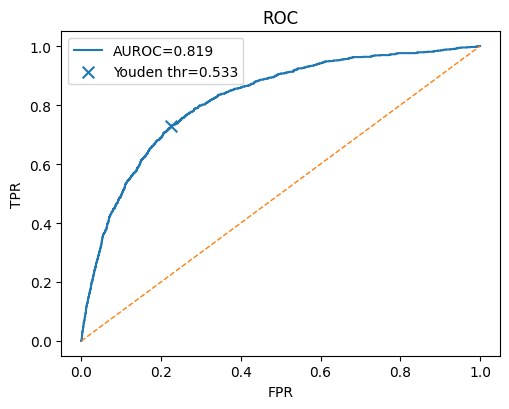

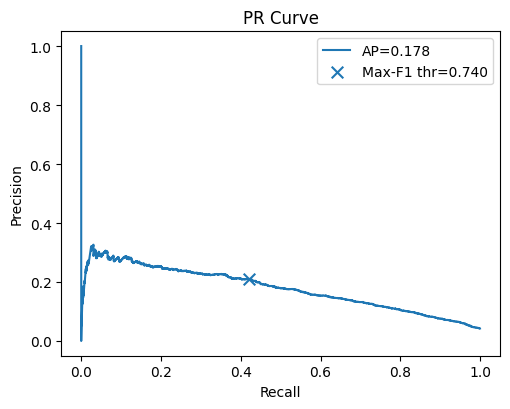

=== Test summary (L2 LR + feature selection) ===
auroc = 0.8188178165295456
average_precision = 0.1779520313241084
best_f1_threshold = 0.7395831569659334
youden_threshold = 0.5331943764348664
at_best_f1 = {'threshold': 0.7395831569659334, 'precision': 0.2100238663484487, 'recall': 0.42105263157894735, 'f1': 0.2802547770700637, 'accuracy': 0.907672195440804, 'tp': 440, 'fp': 1655, 'tn': 21778, 'fn': 605}
at_youden = {'threshold': 0.5331943764348664, 'precision': 0.12594915813799934, 'recall': 0.7301435406698564, 'f1': 0.2148388005068281, 'accuracy': 0.7721627583952937, 'tp': 763, 'fp': 5295, 'tn': 18138, 'fn': 282}
Saved: models\m6a_logreg_L2_featselect_20251012T113427Z.joblib
[save] selected features → models\m6a_logreg_L2_featselect_features.txt


C:\Users\DELL\AppData\Local\Temp\ipykernel_21212\3600405145.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


In [11]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# ---------------- Config ----------------
CORR_THRESHOLD = 0.95
TOPK_UNIV      = 40
L1_C_GRID      = np.logspace(-2, 2, 7)
RANDOM_STATE   = 42
MODEL_NAME     = "m6a_logreg_L2_featselect"
PLOT_PREFIX    = "models/l2_featselect"  # saves _roc.png and _pr.png

# ---------------- Helpers ----------------
def _safe_auc(y_true, x):
    x = pd.Series(x).replace([np.inf, -np.inf], np.nan)
    if x.isna().all() or x.nunique(dropna=True) < 2:
        return np.nan
    x = x.fillna(x.median())
    try:
        return roc_auc_score(y_true, x)
    except Exception:
        return np.nan

def _corr_prune(df: pd.DataFrame, thr: float) -> list[str]:
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > thr)]
    kept = [c for c in df.columns if c not in to_drop]
    print(f"[corr] dropped {len(to_drop)} / {df.shape[1]} columns (>|r|>{thr})")
    return kept

# ---------------- 1) Correlation pruning on TRAIN ONLY ----------------
kept_after_corr = _corr_prune(X_train_df, CORR_THRESHOLD)
Xtr_corr = X_train_df[kept_after_corr]
Xte_corr = X_test_df[kept_after_corr]

# ---------------- 2) Univariate ranking (AUC + Mutual Information) ----------------
imp_uni = SimpleImputer(strategy="median")
Xtr_imp = pd.DataFrame(imp_uni.fit_transform(Xtr_corr), columns=kept_after_corr)

auc_scores = {c: _safe_auc(Y_train, Xtr_imp[c].values) for c in kept_after_corr}
auc_s = pd.Series(auc_scores).sort_values(ascending=False)

mi = mutual_info_classif(Xtr_imp.values, Y_train, random_state=RANDOM_STATE, discrete_features=False)
mi_s = pd.Series(mi, index=kept_after_corr).sort_values(ascending=False)

rank_auc = auc_s.rank(ascending=False, method="average")
rank_mi  = mi_s.rank(ascending=False, method="average")
combo_rank = (rank_auc + rank_mi).sort_values()
topk_univ = list(combo_rank.index[:min(TOPK_UNIV, len(combo_rank))])
print(f"[univariate] selected top-{len(topk_univ)} by combined AUC+MI")

# ---------------- 3) L1-Logistic selection (on pruned set) ----------------
l1cv = LogisticRegressionCV(
    Cs=L1_C_GRID,
    cv=3,
    penalty="l1",
    solver="saga",
    scoring="average_precision",
    class_weight="balanced",
    max_iter=5000,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True,
)
l1cv.fit(Xtr_imp.values, Y_train)
coef = l1cv.coef_.ravel()
l1_kept_idx = np.where(coef != 0)[0]
l1_kept_feats = [kept_after_corr[i] for i in l1_kept_idx]
print(f"[l1] kept {len(l1_kept_feats)} non-zero features (of {len(kept_after_corr)})")

# ---------------- 4) Final feature set ----------------
final_feats = sorted(set(topk_univ).union(l1_kept_feats))
print(f"[final] {len(final_feats)} features selected")

X_train_sel = X_train_df[final_feats].copy()
X_test_sel  = X_test_df[final_feats].copy()

# ---------------- 5) Train L2 Logistic Regression (stable baseline) ----------------
pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        C=1.0,                 # tune if needed; lower = stronger regularization
        class_weight="balanced",
        tol=1e-4,
        max_iter=2000,
        random_state=RANDOM_STATE,
    )),
])

pipe.fit(X_train_sel, Y_train)

# ---------------- 6) Evaluate + Save (using your minimal helpers) ----------------
Path(PLOT_PREFIX).parent.mkdir(parents=True, exist_ok=True)
summary = evaluate_sklearn_minimal(pipe, X_test_sel, Y_test, plot_prefix=PLOT_PREFIX)
print("=== Test summary (L2 LR + feature selection) ===")
for k, v in summary.items():
    print(k, "=", v)

save_model_minimal(pipe, name=MODEL_NAME)

# Also save selected feature names for reproducibility
sel_path = Path("models") / f"{MODEL_NAME}_features.txt"
sel_path.write_text("\n".join(final_feats), encoding="utf-8")
print(f"[save] selected features → {sel_path}")


### MLP(batchnorm+droupout)

class_weight: {0: 0.5238318289425378, 1: 10.990172642762284}
Epoch 1/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auprc: 0.1191 - auroc: 0.7270 - loss: 0.6444 - val_auprc: 0.3104 - val_auroc: 0.8690 - val_loss: 0.2479 - learning_rate: 0.0010
Epoch 2/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auprc: 0.2938 - auroc: 0.8694 - loss: 0.4591 - val_auprc: 0.3534 - val_auroc: 0.8869 - val_loss: 0.2828 - learning_rate: 0.0010
Epoch 3/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auprc: 0.3191 - auroc: 0.8805 - loss: 0.4435 - val_auprc: 0.3584 - val_auroc: 0.8881 - val_loss: 0.3473 - learning_rate: 0.0010
Epoch 4/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auprc: 0.3448 - auroc: 0.8863 - loss: 0.4265 - val_auprc: 0.3657 - val_auroc: 0.8935 - val_loss: 0.3611 - learning_rate: 0.0010
Epoch 5/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auprc: 0.3558 - auroc: 0.8913 - loss: 0.4222 - val_auprc: 0.3831 - val_auroc: 0.8956 - val_loss: 0.3500 - learning_rate: 0.0010
Epoch 6/200
162/162 ━━━━

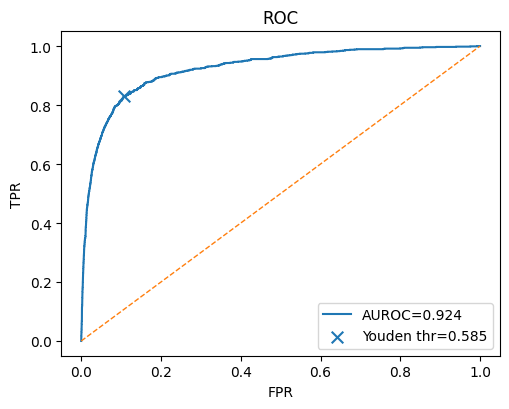

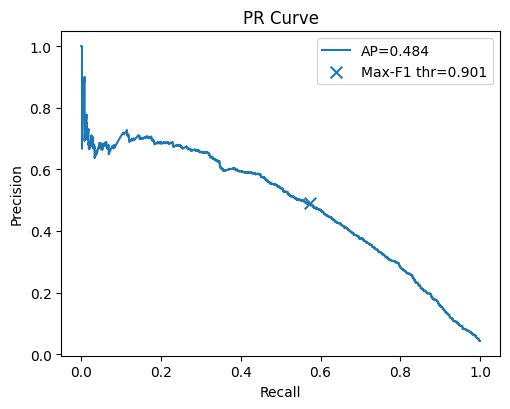

=== Test summary (MLP) ===
auroc = 0.9239433122674705
average_precision = 0.4842355265137503
best_f1_threshold = 0.900544285774231
youden_threshold = 0.5847642421722412
at_best_f1 = {'threshold': 0.900544285774231, 'precision': 0.4905814905814906, 'recall': 0.5732057416267943, 'f1': 0.5286849073256841, 'accuracy': 0.9563689843941499, 'tp': 599, 'fp': 622, 'tn': 22811, 'fn': 446}
at_youden = {'threshold': 0.5847642421722412, 'precision': 0.256508875739645, 'recall': 0.8296650717703349, 'f1': 0.391864406779661, 'accuracy': 0.8900645477571697, 'tp': 867, 'fp': 2513, 'tn': 20920, 'fn': 178}


NameError: name 'save_keras' is not defined

In [ ]:
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------------- Config ----------------
VAL_SIZE     = 0.15
RANDOM_STATE = 42
MODEL_NAME   = "m6a_keras_mlp"
PLOT_PREFIX  = "models/mlp"

# ---------------- Build MLP ----------------
def build_mlp(input_dim, dropout=0.3, lr=1e-3, l2_weight=1e-5):
    inp = keras.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inp)
    for width in [256, 128, 64]:
        x = layers.Dense(width, activation=None,
                         kernel_regularizer=keras.regularizers.l2(l2_weight))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.AUC(curve="PR", name="auprc"),
            keras.metrics.AUC(curve="ROC", name="auroc"),
        ],
    )
    return model

# ---------------- Train/Val split (from TRAIN only) ----------------
sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_STATE)
tr_idx, val_idx = next(sss.split(X_train, Y_train))
X_tr, Y_tr = X_train[tr_idx], Y_train[tr_idx]
X_val, Y_val = X_train[val_idx], Y_train[val_idx]

# ---------------- Class weights for imbalance ----------------
classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=Y_tr)
class_weight = {0: float(weights[0]), 1: float(weights[1])}
print("class_weight:", class_weight)

# ---------------- Build & fit ----------------
model = build_mlp(input_dim=X_train.shape[1], dropout=0.3, lr=1e-3, l2_weight=1e-5)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auprc", mode="max",
        patience=12, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_auprc", mode="max",
        factor=0.5, patience=6, min_lr=1e-5, verbose=1
    ),
]

history = model.fit(
    X_tr, Y_tr,
    validation_data=(X_val, Y_val),
    epochs=200,
    batch_size=512,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1,
)

# ---------------- Evaluate with your helper ----------------
Path(PLOT_PREFIX).parent.mkdir(parents=True, exist_ok=True)
summary = evaluate_keras_minimal(model, X_test, Y_test, plot_prefix=PLOT_PREFIX)
print("=== Test summary (MLP) ===")
for k, v in summary.items():
    print(k, "=", v)

# ---------------- Save with your Keras helper ----------------
save_keras_minimal(model, name=MODEL_NAME, models_dir="models")


Loaded read-level examples: 121838 sites | positives=5475 | negatives=116363
[split] grouping by gene_id
Train/Val/Test sizes: 83305/14701/23832

class_weight: {0: 0.52289161163976, 1: 11.421030984370717}
Epoch 1/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - auprc: 0.1288 - auroc: 0.7414 - loss: 0.5931 - val_auprc: 0.1842 - val_auroc: 0.8055 - val_loss: 0.4747 - learning_rate: 0.0010
Epoch 2/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - auprc: 0.2428 - auroc: 0.8206 - loss: 0.5178 - val_auprc: 0.3194 - val_auroc: 0.8650 - val_loss: 0.5231 - learning_rate: 0.0010
Epoch 3/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - auprc: 0.2690 - auroc: 0.8401 - loss: 0.4981 - val_auprc: 0.3468 - val_auroc: 0.8694 - val_loss: 0.3244 - learning_rate: 0.0010
Epoch 4/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - auprc: 0.2511 - auroc: 0.8437 - loss: 0.4887 - val_auprc: 0.1044 - val_auroc: 0.7702 - val_loss: 0.2234 - learning_rate: 0.0010
Epoch 5/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - aupr

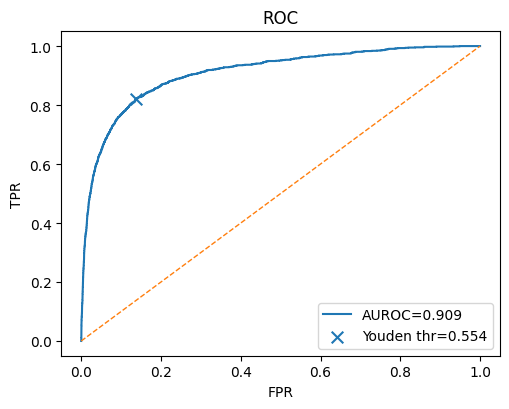

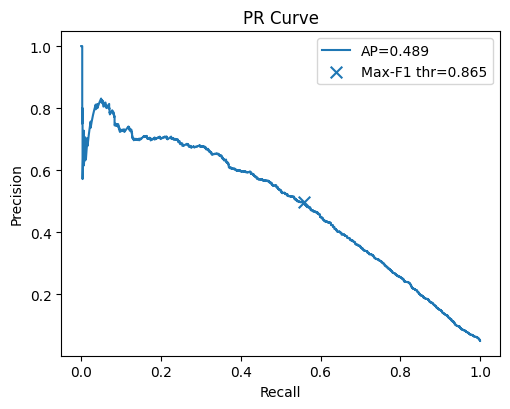

=== Test summary (DeepSets) ===
auroc = 0.9091957884235348
average_precision = 0.4885069152366147
best_f1_threshold = 0.8651009202003479
youden_threshold = 0.5537763833999634
at_best_f1 = {'threshold': 0.8651009202003479, 'precision': 0.49624060150375937, 'recall': 0.5574324324324325, 'f1': 0.5250596658711217, 'accuracy': 0.9498992950654582, 'tp': 660, 'fp': 670, 'tn': 21978, 'fn': 524}
at_youden = {'threshold': 0.5537763833999634, 'precision': 0.23830516776879745, 'recall': 0.8217905405405406, 'f1': 0.3694702866907158, 'accuracy': 0.8606495468277946, 'tp': 973, 'fp': 3110, 'tn': 19538, 'fn': 211}
Saved: models\m6a_deepsets_20251012T125855Z.keras


C:\Users\DELL\AppData\Local\Temp\ipykernel_21212\2714107802.py:34: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


WindowsPath('models/m6a_deepsets_20251012T125855Z.keras')

In [ ]:
import json, gzip, io, os
from pathlib import Path
from typing import Dict, Tuple, List
import numpy as np
import pandas as pd

# ---------- Config ----------
DATA_DIR     = Path("data")
JSON_PATH    = DATA_DIR / "dataset0.json.gz"
LABELS_PATH  = DATA_DIR / "data.info.labelled"
TEST_SIZE    = 0.20
VAL_SIZE     = 0.15
RANDOM_STATE = 42
MAX_READS    = 64
READ_DIM     = 9
MODEL_NAME   = "m6a_deepsets"
PLOT_PREFIX  = "models/deepsets"

label_dtypes = {
    "gene_id": "string",
    "transcript_id": "string",
    "transcript_position": "int32",
    "label": "int8",
}
df_info = pd.read_csv(LABELS_PATH, dtype=label_dtypes)
labels_map: Dict[Tuple[str, int], Tuple[int, str]] = {
    (row.transcript_id, int(row.transcript_position)): (int(row.label), str(row.gene_id))
    for row in df_info.itertuples(index=False)
}

def _open_text(path: Path):
    return gzip.open(path, "rt", encoding="utf-8")

def _iter_records(path: Path):
    """
    Yields dict records of the form:
      { transcript_id: { position: { heptamer: [[9], [9], ...] } } }
    Supports gzipped JSONL, or a single big JSON array.
    """
    with _open_text(path) as f:
        buf = f.read(2048)
        if not buf.strip():
            return
        first_char = next((ch for ch in buf if not ch.isspace()), "")
        if first_char == "{":
            f2 = gzip.open(path, "rt", encoding="utf-8")
            for line in f2:
                line = line.strip()
                if line:
                    yield json.loads(line)
            f2.close()
        else:
            f2 = gzip.open(path, "rt", encoding="utf-8")
            data = json.load(f2)
            f2.close()
            if isinstance(data, list):
                for obj in data:
                    yield obj
            else:
                yield data

# ---------- 2) Extract labeled examples ----------
def extract_examples(json_path: Path, max_reads: int = MAX_READS) -> List[Dict]:
    out = []
    for obj in _iter_records(json_path):
        tid = next(iter(obj))
        tblock = obj[tid]
        pos_key = next(iter(tblock))
        pos = int(pos_key)
        hept_map = tblock[str(pos)] if str(pos) in tblock else tblock[pos]
        heptamer = next(iter(hept_map))
        reads = hept_map[heptamer]
        key = (tid, pos)
        if key not in labels_map:
            continue
        label, gid = labels_map[key]
        # keep only proper 9-dim numeric reads
        clean_reads = []
        for r in reads:
            if isinstance(r, (list, tuple)) and len(r) == READ_DIM:
                try:
                    clean_reads.append([float(x) for x in r])
                except Exception:
                    continue
        if not clean_reads:
            continue
        out.append({
            "gene_id": gid,
            "transcript_id": tid,
            "transcript_position": pos,
            "heptamer": heptamer,
            "reads": clean_reads[:max_reads],  # truncate
            "n_reads": len(clean_reads),
            "label": int(label),
        })
    return out

examples = extract_examples(JSON_PATH, max_reads=MAX_READS)
if not examples:
    raise RuntimeError("No labeled examples found. Check dataset0.json.gz and data.info.labelled alignment.")

df = pd.DataFrame(examples)
print(f"Loaded read-level examples: {len(df)} sites | positives={df['label'].sum()} | negatives={(df['label']==0).sum()}")

# ---------- 3) Pad to fixed size tensors ----------
def pad_reads(reads_list: List[List[float]], max_reads: int, feat_dim: int):
    R = max_reads
    arr = np.zeros((R, feat_dim), dtype=np.float32)
    mask = np.zeros((R,), dtype=bool)
    L = min(len(reads_list), R)
    if L > 0:
        arr[:L, :] = np.asarray(reads_list[:L], dtype=np.float32)
        mask[:L] = True
    return arr, mask

reads_arr = np.zeros((len(df), MAX_READS, READ_DIM), dtype=np.float32)
mask_arr  = np.zeros((len(df), MAX_READS), dtype=bool)
for i, rlist in enumerate(df["reads"]):
    a, m = pad_reads(rlist, MAX_READS, READ_DIM)
    reads_arr[i] = a
    mask_arr[i]  = m

y_all = df["label"].astype(int).to_numpy()

# ---------- 4) Group-aware splits ----------
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

if "gene_id" in df.columns:
    groups = df["gene_id"].astype(str).values
    print("[split] grouping by gene_id")
else:
    groups = df["transcript_id"].astype(str).values
    print("[split] grouping by transcript_id")

gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(reads_arr, y_all, groups=groups))

sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_STATE)
tr_local_idx, val_local_idx = next(sss.split(train_idx.reshape(-1,1), y_all[train_idx]))
tr_idx  = train_idx[tr_local_idx]
val_idx = train_idx[val_local_idx]

Xtr_reads, Xtr_mask, y_tr   = reads_arr[tr_idx],  mask_arr[tr_idx],  y_all[tr_idx]
Xval_reads, Xval_mask, y_val= reads_arr[val_idx], mask_arr[val_idx], y_all[val_idx]
Xte_reads, Xte_mask, y_te   = reads_arr[test_idx], mask_arr[test_idx], y_all[test_idx]

print(f"Train/Val/Test sizes: {len(tr_idx)}/{len(val_idx)}/{len(test_idx)}")

# ---------- 5) DeepSets (Keras 3–friendly attention pooling) ----------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight

def build_deepsets(read_dim=READ_DIM, max_reads=MAX_READS, dropout=0.2, lr=1e-3, hidden=128):
    reads_in = keras.Input(shape=(max_reads, read_dim), name="reads")      # (B, R, 9)
    mask_in  = keras.Input(shape=(max_reads,), dtype="bool", name="mask")  # (B, R)

    # Per-read encoder
    x = layers.Dense(hidden, activation=None)(reads_in)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(hidden, activation="relu")(x)   # (B, R, H)

    # Attention pooling with mask (all via Keras layers / ops)
    logits = layers.Dense(1)(x)                      # (B, R, 1)
    mask_f = layers.Lambda(lambda m: keras.ops.expand_dims(keras.ops.cast(m, "float32"), axis=-1))(mask_in)  # (B,R,1)
    neg_inf = layers.Lambda(lambda m: (1.0 - m) * (-1e9))(mask_f)
    masked_logits = layers.Add()([logits, neg_inf])  # (B, R, 1)
    att = layers.Softmax(axis=1)(masked_logits)      # (B, R, 1)
    weighted = layers.Multiply()([att, x])           # (B, R, H)
    pooled = layers.Lambda(lambda t: keras.ops.sum(t, axis=1))(weighted)   # (B, H)

    # Head
    h = layers.Dense(hidden, activation="relu")(pooled)
    h = layers.Dropout(dropout)(h)
    out = layers.Dense(1, activation="sigmoid")(h)

    model = keras.Model(inputs=[reads_in, mask_in], outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.AUC(curve="PR", name="auprc"),
                 keras.metrics.AUC(curve="ROC", name="auroc")]
    )
    return model

# GPU memory growth (optional)
for g in tf.config.list_physical_devices('GPU'):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

model = build_deepsets()

# Class weights for imbalance
classes = np.array([0, 1])
w = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weight = {0: float(w[0]), 1: float(w[1])}
print("class_weight:", class_weight)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auprc", mode="max", patience=12, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auprc", mode="max", factor=0.5, patience=6, min_lr=1e-5, verbose=1),
]

history = model.fit(
    x=[Xtr_reads, Xtr_mask], y=y_tr,
    validation_data=([Xval_reads, Xval_mask], y_val),
    epochs=200, batch_size=128,
    class_weight=class_weight,
    callbacks=callbacks, verbose=1
)

# ---------- 6) Evaluate & Save ----------
Path(PLOT_PREFIX).parent.mkdir(parents=True, exist_ok=True)

summary = evaluate_keras_minimal(model, [Xte_reads, Xte_mask], y_te, plot_prefix=PLOT_PREFIX)
print("=== Test summary (DeepSets) ===")
for k, v in summary.items():
    print(k, "=", v)

save_keras_minimal(model, name=MODEL_NAME, models_dir="models")
